In [158]:
# for interest, here is how I would make this a software project
# training classifier using hugging face api (high, high level nlp)
# then classifying script text content
# dataset and csv are fomatted and ready to go for api (as in this sofware works)
# will need a valid hugging face api to work- (will fail but illustrates working code) 
!python3 main.py --hugging_face --login --api_key sldkfjdummykey


here
sldkfjdummykey
> ERROR   ❌ Failed to authenticate. Check the passed token is valid!
> ERROR   ❌ Oops! Something failed in AutoNLP backend..
> ERROR   Error code: 401; Details: '{"error":"Unauthorized"}'
Model trianing using autonlp (hugging face api)


####  Here is the software verison with and args parser that I wrote as an example of using hugging face api to train a binary text classifier and an illustration of how I would approach this problem as a piece of end to end software that runs in terminal

In [159]:
# to show you what the args parser -help would return of this sofware 
!python3 main.py --help

usage: main.py [-h] [--input csv INPUT CSV] [--project PROJECT]
               [--split SPLIT] [--col_mapping COL_MAPPING] [--files FILES]
               [--api_key API_KEY] [--resize RESIZE] [--name NAME]
               [--language LANGUAGE] [--task TASK] [--max_models MAX_MODELS]
               [--create_project] [--hugging_face] [--send] [--login] [--make]
               [--train]

Training Calssifier

optional arguments:
  -h, --help            show this help message and exit
  --input csv INPUT CSV
                        relative loacation of input csv for training
  --project PROJECT     poject name
  --split SPLIT         dataset split
  --col_mapping COL_MAPPING
                        text:text, label:target
  --files FILES         formated csv only 2 colls one for text one for target
  --api_key API_KEY     api key from hugging_face account
  --resize RESIZE       Resizes images by percentage as scalar
  --name NAME           project name hugging face
  --language LANGUAGE  

In [160]:
#files
import gdown 
import os
import zipfile

#data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# utils
from pathlib import Path
import time
from tqdm import tqdm

# web
import urllib.request
import requests
from bs4 import BeautifulSoup

# evaluation metrics
from scipy import stats
from scipy.spatial import distance
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

### Start time

In [161]:
#starting time
time.strftime("%H:%M:%S", time.localtime())

'20:46:46'

In [195]:
!ls


README.md        main.py          scripts_html
bechdel.ipynb    pre_scraped      scripts_html.zip
classifier.py    requirments.txt  super_woman.png




<img src="super_woman.png" width=50 height=50 />

## **preamble**
**bechdel criteria:**
- 1. [x] (of film or literature) Has to have at least two women (discrete int) or $\in \mathbb{Z}$
- 2. [x] Talk to each other in (continuous time) or $\in \mathbb{R}$
- 3. [x] Talk about somthing other than a man (not.self) (binary) or $\in \mathbb{B}$ 
 
 
> here the problem is framed as one of comparing those that meet first condition with two different consecutive female first names in script segments and verifieable ground truth - that is the first condition a prediction of passing overall -- this is to gauge whether more detailed anaylis might be needed such as training an NLP classifier. 

In [200]:
def get_scripts(did=None):
    '''this funciton gets scripts using gdown from google drive zip
    unzips and preservs file name'''
    url = 'https://drive.google.com/drive/folders/1PWoip6Hkl-3WG9Syyd_IxOPeC-FsshDP?usp=sharing'
    os.makedirs(did,exist_ok=True)
    gdown.download_folder(url,output=None,quiet=False)
    fid = Path('scripts_html.zip')
    with zipfile.ZipFile(fid, 'r') as zip_fid:
        zip_fid.extractall(fid.parent)
# path to scripts 
did = Path('pre_scraped/')
os.makedirs(did,exist_ok=True)
get_scripts(did)
did = Path('scripts_html/')
# using path object as itterator to ge file in directory
fids = [fid for fid in did.iterdir()]
scripts = { }
for fid in tqdm(fids):
    with open(fid,'r') as handle:
        scripts[fid.name.strip(fid.suffix)]=BeautifulSoup(handle, 'html.parser')

Retrieving folder list


Processing file 1sKXHb17Ah6Bl6nVMCUE--SnCGV-rvlzk scripts_html.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1sKXHb17Ah6Bl6nVMCUE--SnCGV-rvlzk
To: /Users/fridades/Projects/bechdel/scripts_html.zip
100%|██████████████████████████████████████| 16.1M/16.1M [00:01<00:00, 8.99MB/s]
Download completed
100%|█████████████████████████████████████████| 282/282 [00:16<00:00, 17.12it/s]


In [194]:
def clean(script):
    script = [element for element in script.find_all('b')]
   
    script = [element.get_text() for element in script]
 
    script = [" ".join(element.split()) for element in script
              if " ".join(element.split()) !='']
    return [element.upper() for element in script]

# make dict for ease of manipulation later and if need to save as .json
names_dict = {script:clean(scripts[script]) for script in scripts}
names_dict = {key.strip(', The').upper():names_dict[key] for key in names_dict}
#clean names and make upper


In [167]:
#get list of first names (man and woman from academic source)
women_names ='https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt'
man_names = 'https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt'
gdown.download(women_names);gdown.download(man_names)

Downloading...
From: https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt
To: /Users/fridades/Projects/bechdel/female.txt
35.8kB [00:00, 58.1MB/s]                                                        
Downloading...
From: https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt
To: /Users/fridades/Projects/bechdel/male.txt
20.5kB [00:00, 33.6MB/s]                                                        


'male.txt'

In [168]:
def read_text(fid):
    '''gets names from txt removing preamble (prints)
    prints first name converted to upper'''
    with open(fid,'r') as hndl:
        txt = hndl.read().splitlines()
    preamble = txt[:5]
    #convert all names to upper
    txt = [name.upper() for name in txt[5:]]
    print(preamble,'\n', txt[1])
    return txt

# get lists
fem_first, man_first = read_text('female.txt'), read_text('male.txt')

['# List of common female names.', '# Copyright (c) January 1991 by Mark Kantrowitz.', '# 4987 names', '# Thanks to Bill.Ross for about 1000 additional names.', '# Version 1.3 (29-MAR-94)'] 
 ABAGAEL
['# List of common male names.', '# Copyright (c) January 1991 by Mark Kantrowitz.', '# 2940 names', '# Thanks to Bill Ross for about 1000 additional names.', '# Version 1.3 (29-MAR-94)'] 
 AAMIR


In [169]:
# might take a minute to parse and compute (but less time than training an nlp model :-))
def bechdel_one(script_names,fems):
    '''a generator function that yields whther or not condtion 1
    is passed where 2 female names not the same in seqence are 
    a potential proxy for passing condition 1 of Bechdel test'''
    for idx,name in enumerate(script_names[3:]):
        if idx+1!=len(script_names):
            dialoge = script_names[idx:idx+2]
            #not the same person
            not_solo = dialoge[0]!=dialoge[1]
            # first person is in womens names
            a_is_girl = dialoge[0] in fems
            # secong perons is in womens names
            b_is_girl = dialoge[1] in fems
            yield all([not_solo,a_is_girl,b_is_girl])
    
passes_bechdel_one = {title:any(list(bechdel_one(names_dict[title],fem_first))) for title in names_dict}

In [170]:
# passed condition one according to boolean process

passes_bechdel_one['10 THINGS I HATE ABOUT YOU']

True

189

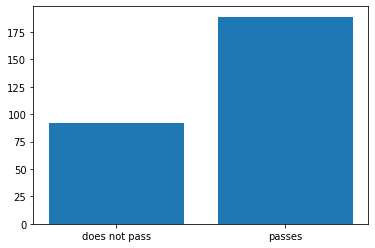

In [171]:
passes_one_vector = np.array([passes_bechdel_one[key] for key in passes_bechdel_one])
#convert bools to ints
passes_one_vector = passes_one_vector.astype(int)
len(passes_one_vector)
plt.bar(['does not pass','passes'],np.bincount(passes_one_vector))
np.count_nonzero(passes_one_vector)

In [172]:
time.strftime("%H:%M:%S", time.localtime())

'20:48:18'

####  list of film titles that pass all three conditions from bechdeltest.com (here taken as **ground truth**)

In [173]:
bechdel_films = requests.get('https://bechdeltest.com/?list=all').text

In [174]:
 bechdel_soup = BeautifulSoup(bechdel_films, 'html.parser')

In [175]:
criteria = "[There are two or more women in this movie and they talk to each other about something other than a man]"
films = bechdel_soup.find_all('a')
titles_that_pass = [films[idx-2].text for idx,film in enumerate(films) if criteria in str(film.contents)]
titles_that_pass = [title.upper().strip('THE ') for title in titles_that_pass if title !='']
to_check = [title.strip(', The').upper() for title in list(names_dict.keys())]
len(to_check)

281

In [176]:
# 1*n d array (aka a vector) of those that pass all 1=pass 0=fail
pass_all_vector = np.array([i in titles_that_pass for i in to_check]).astype(int)

<BarContainer object of 2 artists>

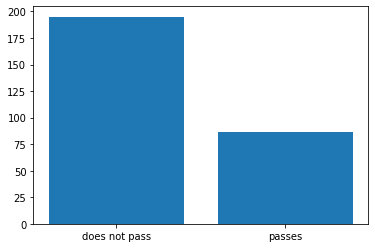

In [177]:
plt.bar(['does not pass','passes'],np.bincount(pass_all_vector))

In [178]:
np.count_nonzero(pass_all_vector)

86

#### PLCC vanilla correlation coeff (can be used for binary and give phi coefficinet) to compare method used to derive condition one with ground truth (human rated unambiguous passes of Bechdel test
$$\begin{equation}
r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i -\overline{y})}{\sqrt{\sum_{i=1}^{n} (x_i -\overline{x})^2(y_i - \overline{y})^2}}
\label{PLCC} 
\end{equation}$$

In [179]:
pearson_r, p_val = stats.pearsonr(passes_one_vector,pass_all_vector)
f'R value = {pearson_r:.3f} P value {p_val:.3f}'

'R value = -0.080 P value 0.183'

#### Shows that not very significant prediction and that either the method of using sequential female names is not very good or that it is a poor proxy for passing the Bechdel test

#### hack proof using mathews (specifically binary) PLCC vanilla correlation coeff (can be used for binary as and give phi coefficinet)

$$\begin{equation}
    MMC = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{equation}$$

In [180]:
f' Mathews coef = {matthews_corrcoef(pass_all_vector,passes_one_vector):.3f}'

' Mathews coef = -0.080'

#### however perhaps more appropriate as shows 'set similarity' is Jacard's Distance (a bit like SSIM but for binary vectors)
$$\begin{equation}
    d_j(A,B) = 1-J(A,B) = \frac{| A \cup B| - | A \cap B|}{| A \cup B|}
\end{equation}$$

In [181]:
f' Jackards Dist = {distance.jaccard(pass_all_vector,passes_one_vector):.3f}'

' Jackards Dist = 0.761'

#### shows significant distance however about 1/3 of sample space is same 
> therefore while poor correlation (between those that pass condition 1 of bechdel and are in ground truth) ther is some promise that those that meet two fmale charachter names being used in seqece maight be good a prediction condition one but that the textuall content accounts for faliure of the Bechdel test after this (indicates that textuall analysis is needed)!!

#### Show if condition of one by names method is a an accurate predictory of all three. 

$$\begin{equation}
    Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation}$$

In [182]:
tn, fp, fn, tp = confusion_matrix(pass_all_vector,passes_one_vector).ravel()

f'accuracy = {sum([tp,tn])/sum([tn,fp,fn,tp]):.3f}'

'accuracy = 0.399'

In [183]:
main_films = requests.get('https://imsdb.com/all-scripts.html').text
main_films = BeautifulSoup(main_films, 'html.parser')

In [184]:
script_urls = [ ]
for i in main_films.find_all('a'):
    if '/Movie Scripts/' in i['href']:
        if i.text.strip(' ,The').upper() not in passes_bechdel_one:
            url = 'https://imsdb.com'+str(i['href'])
            script_urls.append(url)

In [185]:
script_urls[0].split('/')[-1].strip('.html').strip(', The').upper()

'RESERVOIR DOGS SCRIP'

In [186]:
'https://imsdb.com/Movie%20Scripts/Four%20Rooms%20Script.html'
def get_script(parent_page):
    '''gets script form parent html (script page 
    rather thatn script itself)'''
    one_film = requests.get(parent_page).text
    one_film = BeautifulSoup(one_film, 'html.parser')
    for i in one_film.find_all('a'):
        if 'Read' in i.text:
            # get one script
            one_script = requests.get(
                'https://imsdb.com/Movie Scripts'+i['href']).text
            return BeautifulSoup(one_script, 'html.parser')
        

#### probably a bit exaggerated on the evasion of web crawl blocking but illustrates  some techniques for this

In [187]:
script_urls = np.array(script_urls)
# random shuffle urls array so (evasion of blocking)
np.random.shuffle(script_urls)
constant = 100
#batching scripts into 100 to take a 
#longer break of random time every 100 scrapes
batches = [script_urls[i-constant:i] 
           for i in range(constant,len(script_urls),constant)]

new_scripts =  { }
for batch in tqdm(batches):
    # random sleep of uniform probability (evasion of blocking)
    for url in batch:
        #sleep_for = sum(np.random.random_sample(1))*0.5
        # micro sleep to emulate unpredictable behaviour
        #time.sleep(sleep_for)
        title = url.split('/')[-1].strip('.html').strip(', The').upper()
        # try as some pages migh be irregular/not parsed etc
        try:
            script = clean(get_script(url))
            new_scripts[title]=script
        except:
            print(title, 'not parsed')

  0%|                                                     | 0/9 [00:00<?, ?it/s]

GREMLINS 2 SCRIP not parsed
FURY SCRIP not parsed
CONTACT SCRIP not parsed
DONNIE DARKO SCRIP not parsed


 11%|█████                                        | 1/9 [00:48<06:29, 48.70s/it]

WHAT ABOUT BOB? SCRIP not parsed
O BROTHER WHERE ART THOU? SCRIP not parsed
BATMAN FOREVER SCRIP not parsed
BATMAN RETURNS SCRIP not parsed


 22%|██████████                                   | 2/9 [01:36<05:38, 48.38s/it]

BATMAN BEGINS SCRIP not parsed
HARRY POTTER AND THE HALF-BLOOD PRINCE SCRIP not parsed
OUTBREAK SCRIP not parsed
EXECUTIVE DECISION SCRIP not parsed
HARRY POTTER AND THE GOBLET OF FIRE SCRIP not parsed


 33%|███████████████                              | 3/9 [02:25<04:51, 48.53s/it]

VALENTINE'S DAY SCRIP not parsed


 44%|████████████████████                         | 4/9 [03:14<04:04, 48.85s/it]

UNFORGIVEN SCRIP not parsed
MATCHSTICK MEN SCRIP not parsed
HARRY POTTER AND THE CHAMBER OF SECRETS SCRIP not parsed


 56%|█████████████████████████                    | 5/9 [04:04<03:16, 49.10s/it]

GOODFELLAS SCRIP not parsed
LETHAL WEAPON SCRIP not parsed
CASABLANCA SCRIP not parsed
BATMAN AND ROBIN SCRIP not parsed


 67%|██████████████████████████████               | 6/9 [04:54<02:28, 49.43s/it]

EYES WIDE SHUT SCRIP not parsed
GINGER SNAPS SCRIP not parsed


 78%|███████████████████████████████████          | 7/9 [05:46<01:39, 50.00s/it]

WHO FRAMED ROGER RABBIT? SCRIP not parsed


 89%|████████████████████████████████████████     | 8/9 [06:33<00:49, 49.38s/it]

DARK KNIGHT, THE SCRIP not parsed
HARRY POTTER AND THE DEATHLY HALLOWS PART 1 SCRIP not parsed


100%|█████████████████████████████████████████████| 9/9 [07:25<00:00, 49.46s/it]


In [146]:
len(new_scripts)

866

In [147]:
new_script = {key.replace('THE SCRIP','').replace('SCRIP',''):new_scripts[key] for key in new_scripts}

In [148]:
all_scripts = {**names_dict, **new_script}
print(f'there are now {len(all_scripts)} scripts scraped')
passes_bechdel_one = {title:any(list(bechdel_one(all_scripts[title],fem_first))) for title in all_scripts}

there are now 1147 scripts scraped


748

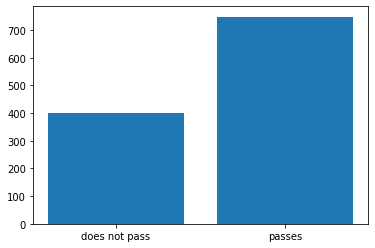

In [149]:
passes_one_vector = np.array([passes_bechdel_one[key] for key in passes_bechdel_one])
#convert bools to ints
passes_one_vector = passes_one_vector.astype(int)
len(passes_one_vector)
plt.bar(['does not pass','passes'],np.bincount(passes_one_vector))
np.count_nonzero(passes_one_vector)

<BarContainer object of 2 artists>

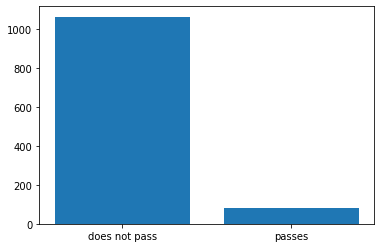

In [150]:
pass_all_vector = np.array([i in titles_that_pass for i in all_scripts]).astype(int)
plt.bar(['does not pass','passes'],np.bincount(pass_all_vector))

In [151]:
pearson_r, p_val = stats.pearsonr(passes_one_vector,pass_all_vector)
f'R value = {pearson_r:.3f} P value {p_val:.3f}'

'R value = -0.022 P value 0.455'

In [152]:
f' Mathews coef = {matthews_corrcoef(pass_all_vector,passes_one_vector):.3f}'

' Mathews coef = -0.022'

In [153]:
f' Jackards Dist = {distance.jaccard(pass_all_vector,passes_one_vector):.3f}'

' Jackards Dist = 0.935'

In [154]:
tn, fp, fn, tp = confusion_matrix(pass_all_vector,passes_one_vector).ravel()

f'accuracy = {sum([tp,tn])/sum([tn,fp,fn,tp]):.3f}'

'accuracy = 0.364'